## Dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from transformers import AutoTokenizer
import gensim
from gensim.parsing.preprocessing import remove_stopwords
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

import xgboost as xgb

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')


/opt/anaconda3/envs/dev2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/venkatvarunthamma/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# If using Google Colab then pip install dependencies and downgrade the scikit-learn version 
# along with others if you are not able to run the code on Colab  

# !pip install pandas numpy seaborn matplotlib wordcloud transformers gensim scikit-learn nltk xgboost
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# from google.colab import drive
# drive.mount('/content/drive')

## Visualizations

In [2]:
# Data Set came from https://www.kaggle.com/datasets/cynthiarempel/amazon-us-customer-reviews-dataset/data?select=amazon_reviews_us_Camera_v1_00.tsv
file = "amazon_reviews_us_Camera_v1_00.tsv"

#reading tsv file
csv_table = pd.read_table(file, sep='\t', on_bad_lines='skip')

#converting tsv file into csv
csv_table.to_csv('camera_reviews.csv', index=False)

df = pd.read_csv('camera_reviews.csv')

df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,2975964,R1NBG94582SJE2,B00I01JQJM,860486164,GoPro Rechargeable Battery 2.0 (HERO3/HERO3+ o...,Camera,5,0,0,N,Y,Five Stars,ok,2015-08-31
1,US,23526356,R273DCA6Y0H9V7,B00TCO0ZAA,292641483,Professional 58mm Center Pinch Lens Cap for CA...,Camera,5,0,0,N,Y,Love it!!!,"Perfect, even sturdier than the original!",2015-08-31
2,US,52764145,RQVOXO7WUOFK6,B00B7733E0,75825744,Spy Tec Z12 Motion Activated Intelligent Secur...,Camera,2,1,1,N,Y,Another Motion Detect Fail,"If the words, &#34;Cheap Chinese Junk&#34; com...",2015-08-31
3,US,47348933,R1KWKSF21PO6HO,B006ZN4U34,789352955,"Celestron UpClose G2 10x25 Monocular, Black (7...",Camera,5,0,0,N,Y,Exactly what I wanted and expected.,Exactly what I wanted and expected. Perfect fo...,2015-08-31
4,US,33680700,R38H3UO1J190GI,B00HUEBGMU,19067902,Vidpro XM-L Wired Lavalier microphone - 20' Au...,Camera,5,1,1,N,Y,Good mic at a Good Price...Not Canon Though.,I will look past the fact that they tricked me...,2015-08-31


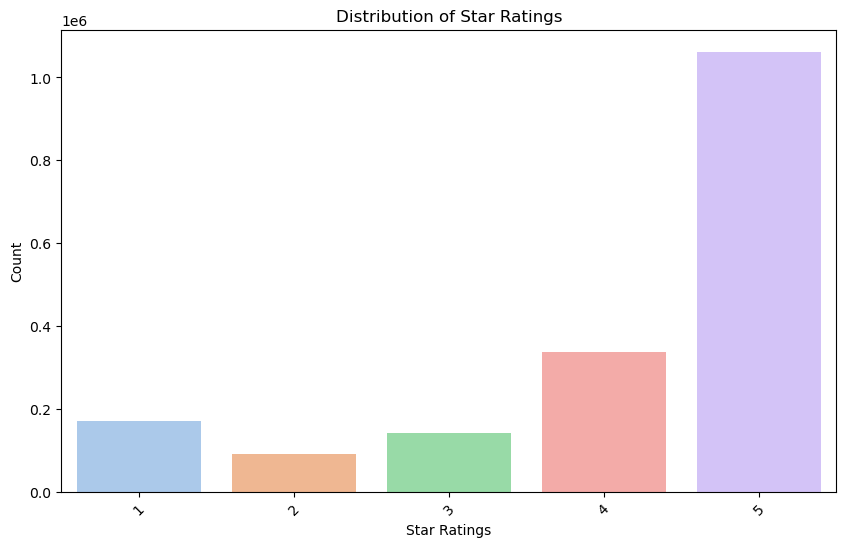

In [3]:
def column_chart(attribute, label):
  plt.figure(figsize=(10, 6))
  sns.countplot(x=attribute, data=df, palette='pastel')
  plt.xlabel(label)
  plt.ylabel('Count')
  plt.title(f'Distribution of {label}')
  plt.xticks(rotation=45)
  plt.show()

column_chart('star_rating', 'Star Ratings')

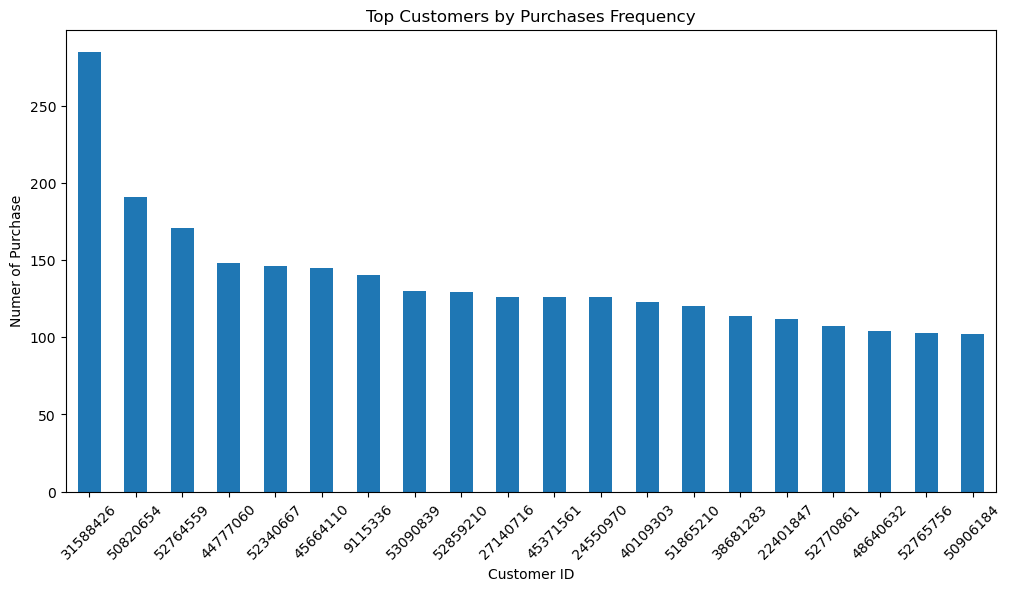

In [ ]:
def plot_customer_purchase_freq(attribute, num_customer):
    customer_counts = df[attribute].value_counts().nlargest(num_customer)
    
    # create the bar chart
    plt.figure(figsize=(12, 6))
    customer_counts.plot(kind='bar')
    plt.xlabel('Customer ID')
    plt.ylabel('Numer of Purchase')
    plt.title(f'Top Customers by Purchases Frequency'.format(num_customer))
    plt.xticks(rotation=45)
    plt.show()

plot_customer_purchase_freq('customer_id', 20)

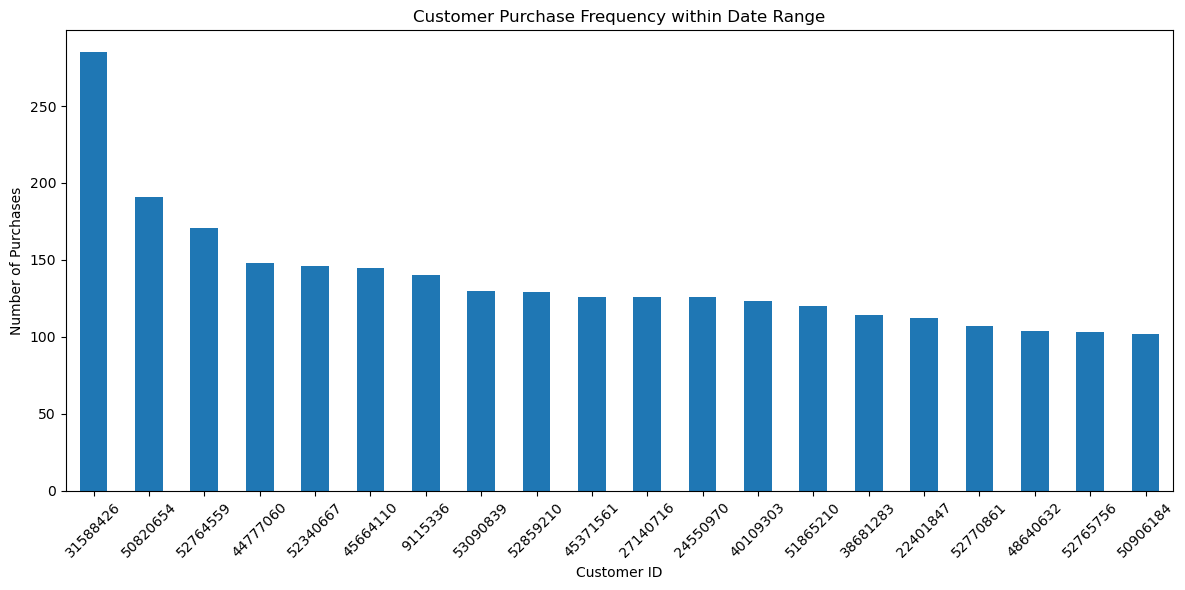

In [ ]:

def plot_customer_purchase_frequency_date_range(data, num_customer, start_date=None, end_date=None):
    """
    Plots a bar chart of customer purchase frequency within a specified date range.

    Args:
        data (pd.DataFrame): DataFrame containing 'customer_id' and 'review_date' columns.
        start_date (str, optional): Start date for the analysis (YYYY-MM-DD). Defaults to None (no start date limit).
        end_date (str, optional): End date for the analysis (YYYY-MM-DD). Defaults to None (no end date limit).
    """

    # Input validation
    if 'customer_id' not in data.columns or 'review_date' not in data.columns:
        print("Error: 'customer_id' or 'review_date' column not found.")
        return

    try:
        data['review_date'] = pd.to_datetime(data['review_date'])
    except ValueError:
        print("Error: 'review_date' column must be in YYYY-MM-DD format.")
        return

    # Apply date range filter
    if start_date:
        try:
            start_date = pd.to_datetime(start_date)
            data = data[data['review_date'] >= start_date]
        except ValueError:
            print("Error: Invalid start_date format. Use YYYY-MM-DD.")
            return
    if end_date:
        try:
            end_date = pd.to_datetime(end_date)
            data = data[data['review_date'] <= end_date]
        except ValueError:
            print("Error: Invalid end_date format. Use YYYY-MM-DD.")
            return

    # Count purchases per customer
    customer_counts = data['customer_id'].value_counts().nlargest(num_customer)

    #Plot the bar chart
    plt.figure(figsize=(12, 6))
    customer_counts.plot(kind='bar')
    plt.title('Customer Purchase Frequency within Date Range')
    plt.xlabel('Customer ID')
    plt.ylabel('Number of Purchases')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Call the function (no date range specified)
#plot_customer_purchase_frequency_date_range(df, 20)

# Call the function with a start date
#plot_customer_purchase_frequency_date_range(df, 20, start_date='1995-08-25')

# Call the function with a start and end date
plot_customer_purchase_frequency_date_range(df, 20,start_date='2000-01-01', end_date='2015-08-31')



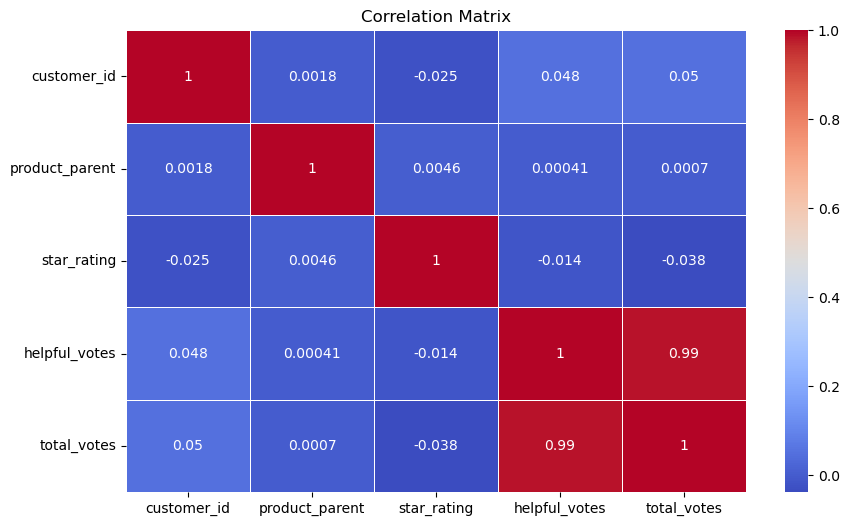

In [ ]:
# Function to display correlation matrix using Pandas corr function
def correlation_matrix():
  corr_matrix = df.corr(numeric_only=True)
  plt.figure(figsize=(10, 6))
  sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
  plt.title('Correlation Matrix')
  plt.show()

correlation_matrix()

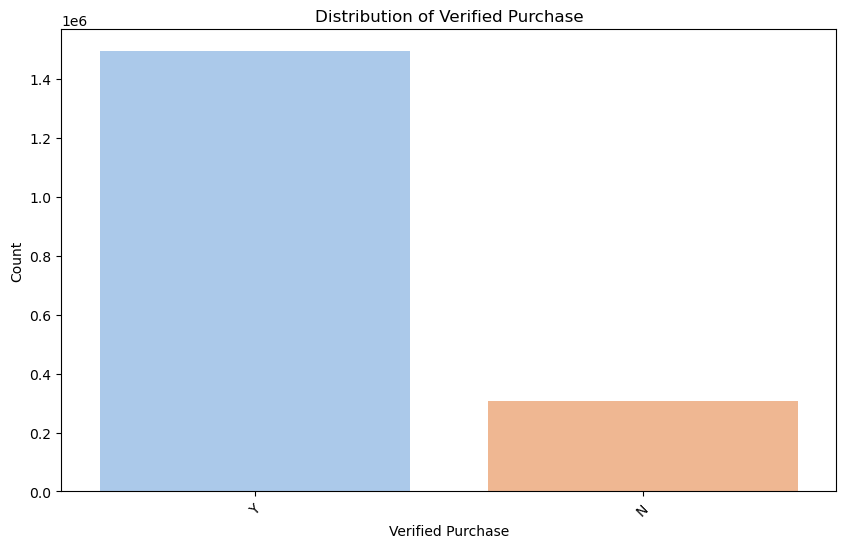

In [4]:
column_chart('verified_purchase', 'Verified Purchase')

In [5]:
df['review_combined'] = df.review_body + ' ' + df.review_headline + ' ' + df.product_title

print(df.review_combined.isna().sum())
df.dropna(subset=['review_combined'], inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.review_combined.isna().sum())

110
0


In [6]:
reviews_data = df[['star_rating', 'review_combined', 'review_date']]
reviews_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800735 entries, 0 to 1800734
Data columns (total 3 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   star_rating      int64 
 1   review_combined  object
 2   review_date      object
dtypes: int64(1), object(2)
memory usage: 41.2+ MB


In [7]:
review_http = reviews_data[reviews_data.review_combined.str.contains(r'^(?=.*/>)(?=.*http)')]
review_http

,star_rating,review_combined,review_date
181,1,"We purchased a Defender brand DVR on March 3, ...",2015-08-31
604,1,"We purchased a Defender brand DVR on March 3, ...",2015-08-31
637,1,"We purchased a Defender brand DVR on March 3, ...",2015-08-31
681,1,"We purchased a Defender brand DVR on March 3, ...",2015-08-31
989,5,The Phantom 3 is awesome! Check this out:<br ...,2015-08-31
...,...,...,...
1769779,5,Addendum 3/30: To correct the guy correcting ...,2005-01-17
1771232,5,Did a bit of online research after reading ano...,2004-11-22
1777616,1,This is a prime example of the risks of buying...,2003-12-30
1798944,1,Good cheap cam with nice features...<br />Has ...,2000-08-15


In [8]:
review_emoji = reviews_data[reviews_data.review_combined.str.contains('❤')]
review_emoji

,star_rating,review_combined,review_date
4145,5,Absolutely love it❤️ Five Stars Fujifilm Mini ...,2015-08-29
10683,5,I love my Manfrotto! Amazing bag!❤️ Manfrotto ...,2015-08-25
11476,5,Great bag!🎒 Got it for my boyfriend as a bday ...,2015-08-25
12697,5,My grandaughter absolutely loved this camera. ...,2015-08-24
27811,5,Impressed - love it! ❤<br />Never thought I'd ...,2015-08-16
...,...,...,...
760513,5,❤️ It has exceeded my expectations! Focus came...,2014-05-14
868183,5,"Using my mothers account, I would like to say ...",2014-01-25
890172,5,I have been a big fan of Holdfast Gear since t...,2014-01-07
1183666,5,This Deluxe DB Roth Accessory starter kit work...,2013-02-15


In [9]:
review_http_list = review_http.index.to_list()
emoji_list = review_emoji.index.to_list()

list(set(review_http_list) & set(emoji_list))

[77840, 81563, 100174, 81659]

In [10]:
reviews_data.loc[:,'cleaned_reviews'] = reviews_data['review_combined'].apply(lambda x: re.sub(r'<[^>]+>|\W|http\S+', ' ', x.lower()))

In [11]:
def remove_stopwords(text):
    # Call the gensim's remove_stopwords function instead of recursing
    return gensim.parsing.preprocessing.remove_stopwords(text)

reviews_data['combined-without-stopwords'] = reviews_data['review_combined'].apply(remove_stopwords)
reviews_data['cleaned_without_stopwords'] = reviews_data['cleaned_reviews'].apply(remove_stopwords)

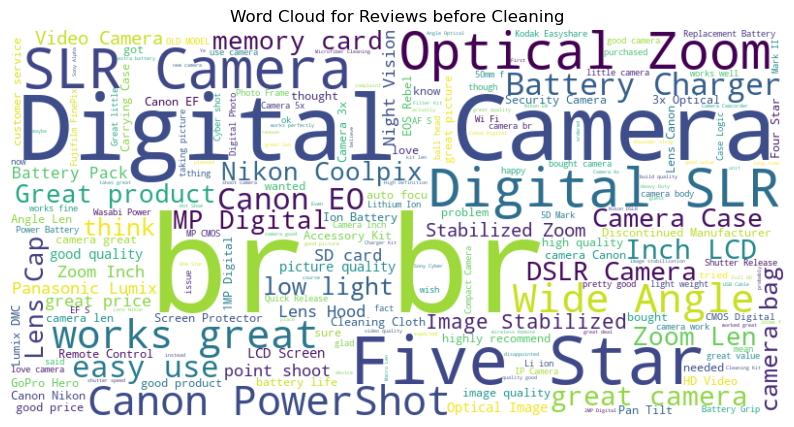

In [12]:
def worl_cloud(attribute, label):
  all_reviews_combined = " ".join(reviews_data[attribute])
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews_combined)
  plt.figure(figsize=(10, 6))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Word Cloud for {label}')
  plt.show()

worl_cloud('combined-without-stopwords', 'Reviews before Cleaning')

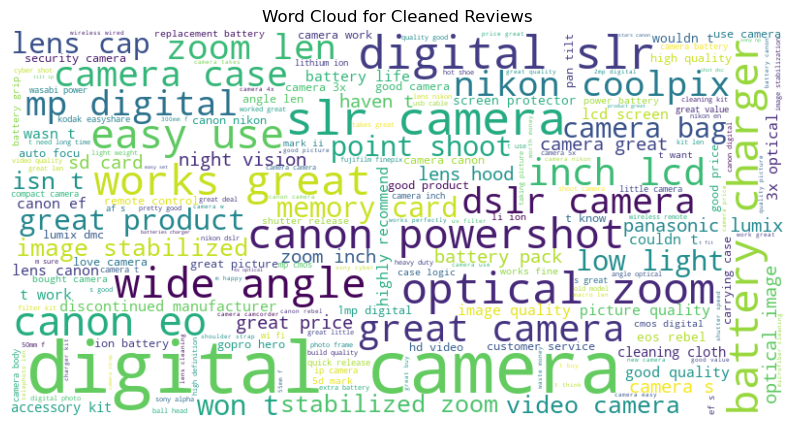

In [ ]:
worl_cloud('cleaned_without_stopwords', 'Cleaned Reviews')

[('I', 3839617), ('camera', 1243783), ('The', 927106), ('Camera', 791379), ('Canon', 600342), ('/><br', 584405), ('Digital', 579179), ('It', 518735), ('great', 482848), ('-', 474655), ('good', 460881), ('use', 455441), ('lens', 452848), ('This', 452097), ('Nikon', 401179), ('like', 386334), ('Lens', 338376), ('quality', 305028), ('battery', 304675), ('Great', 303581)]


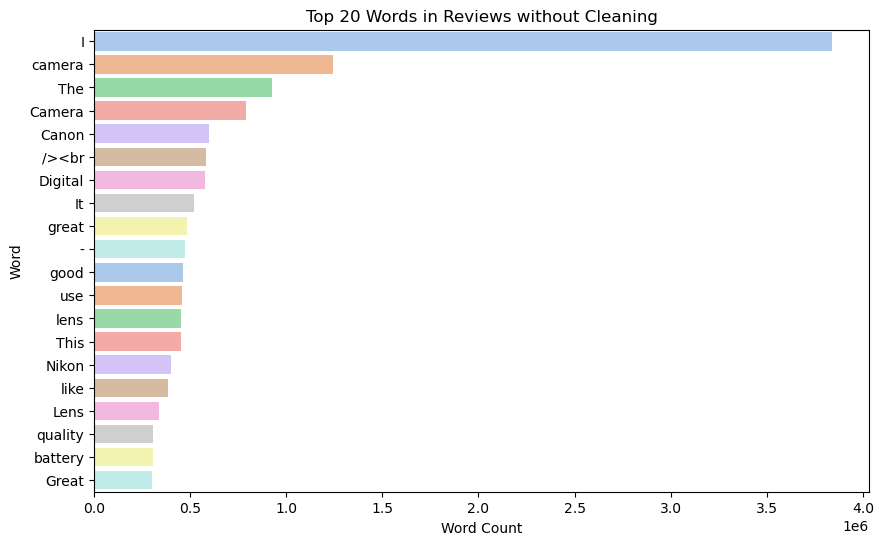

In [13]:
def barplot_most_freq_words(attribute, num_of_words, label):
    words = ' '.join(reviews_data[attribute]).split()
    word_counts = Counter(words)
    
    # Get top 20 words and their counts
    top_n_words = word_counts.most_common(num_of_words)
    print(top_n_words)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=[word[1] for word in top_n_words], y=[word[0] for word in top_n_words], palette='pastel')
    plt.xlabel('Word Count')
    plt.ylabel('Word')
    plt.title(f'Top 20 Words in {label}')
    plt.show()

barplot_most_freq_words('combined-without-stopwords', 20, 'Reviews without Cleaning')

[('camera', 2581954), ('lens', 997432), ('great', 977824), ('t', 880911), ('s', 828625), ('canon', 701971), ('good', 700654), ('digital', 691204), ('battery', 667128), ('use', 595434), ('nikon', 466036), ('2', 458495), ('quality', 441647), ('like', 426952), ('case', 423798), ('3', 419782), ('cameras', 408623), ('1', 397923), ('zoom', 397565), ('video', 396422)]


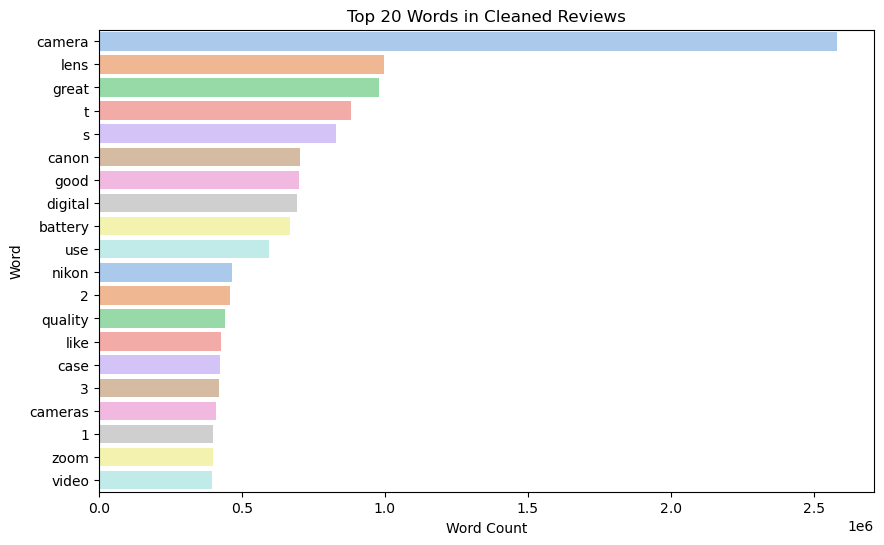

In [14]:
barplot_most_freq_words('cleaned_without_stopwords', 20, 'Cleaned Reviews')

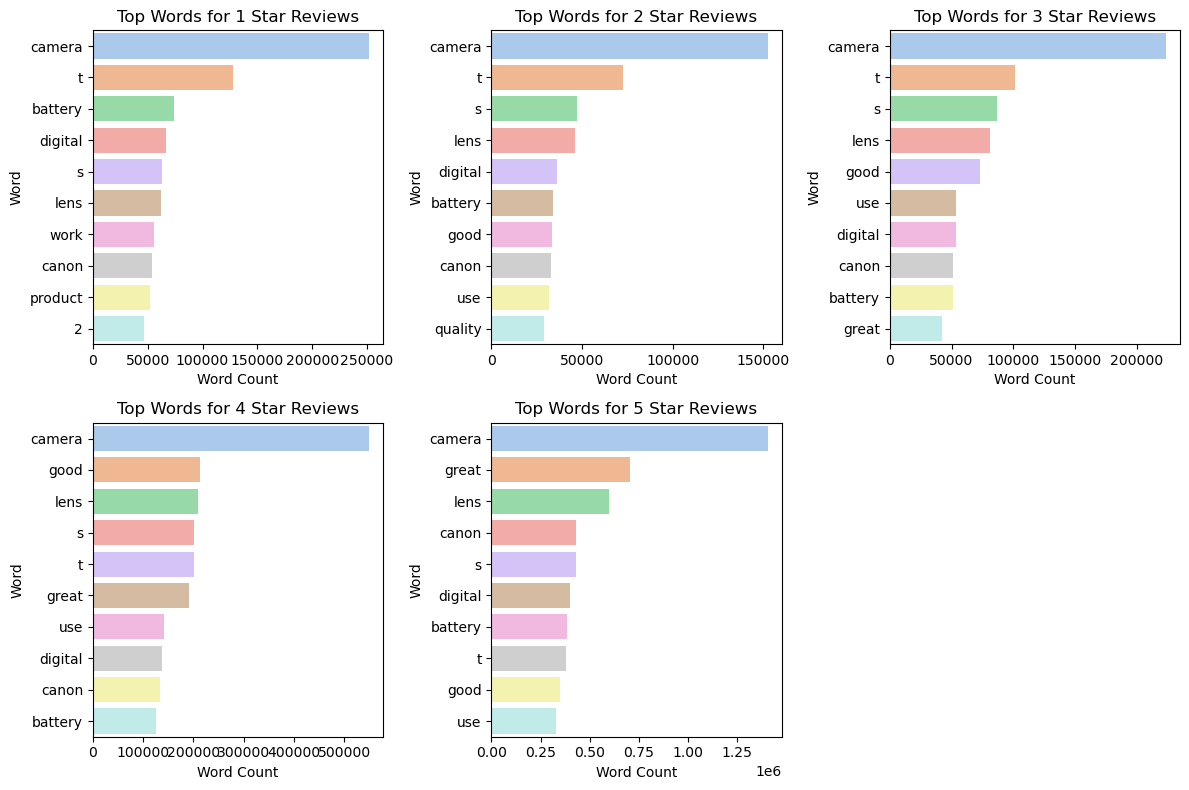

In [15]:
def barpot_for_ratings(attribute1, attribute2, num_of_words):
    top_n_words_per_rating = {}
    for rating in range(1, 6):
        words = ' '.join(reviews_data[reviews_data[attribute2] == rating][attribute1]).split()
        word_counts = Counter(words)
        top_n_words_per_rating[rating] = word_counts.most_common(num_of_words)

    plt.figure(figsize=(12, 8))
    for rating, top_words in top_n_words_per_rating.items():
        plt.subplot(2, 3, rating)
        sns.barplot(x=[word[1] for word in top_words], y=[word[0] for word in top_words], palette='pastel')
        plt.xlabel('Word Count')
        plt.ylabel('Word')
        plt.title(f'Top Words for {rating} Star Reviews')
    plt.tight_layout()
    plt.show()

barpot_for_ratings('cleaned_without_stopwords', 'star_rating', 10) 

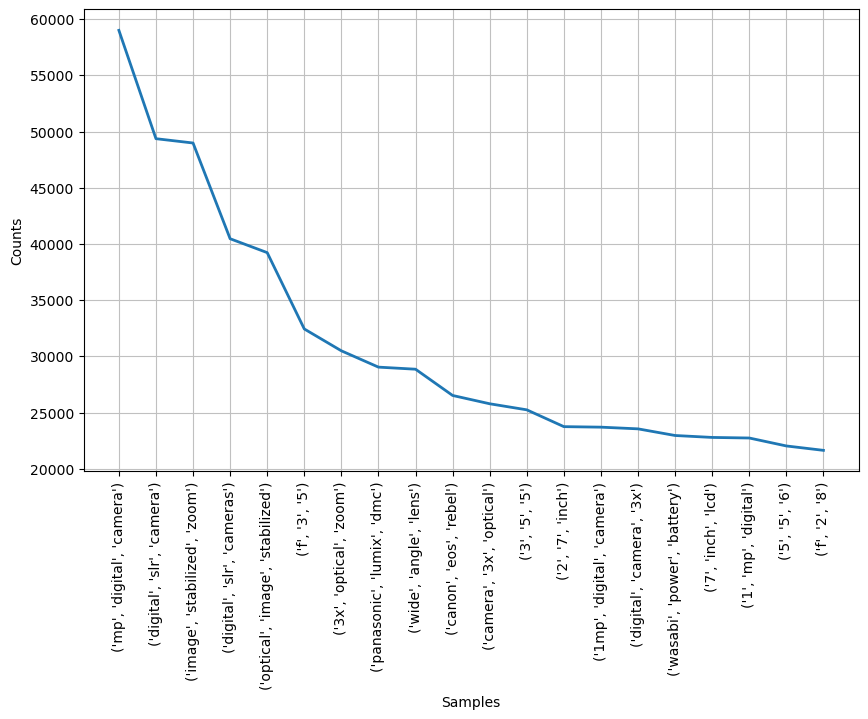

In [ ]:
from nltk.util import ngrams
from nltk import FreqDist
def plot_ngram(attribute, n):
    all_words = ' '.join(reviews_data[attribute]).split()
    n_grams = list(ngrams(all_words, n))
    n_gram_freq = FreqDist(n_grams)
    
    plt.figure(figsize=(10, 6))
    n_gram_freq.plot(20, cumulative=False)

    plt.show()

plot_ngram('cleaned_without_stopwords', 3)


## Spam Filter

In [ ]:
df = pd.read_csv("amazon_reviews_us_Camera_v1_00.tsv", delimiter="\t", on_bad_lines="skip")

In [ ]:
# Printing the dataset
df.head()

In [ ]:
# CLeaning

# Keep only the necessary columns
df = df[["customer_id", "review_id", "product_id", "star_rating", "helpful_votes",
         "total_votes", "vine", "verified_purchase", "review_headline", "review_body", "review_date"]]

In [ ]:
# Fill missing values in Review Body
df["review_body"] = df["review_body"].fillna("No Review")

In [ ]:
# Convert Number Columns to Integers
df["customer_id"] = df["customer_id"].astype(int)
df["star_rating"] = df["star_rating"].astype(int)
df["helpful_votes"] = df["helpful_votes"].astype(int)
df["total_votes"] = df["total_votes"].astype(int)

# Convert Word Columns to Strings
df["review_headline"] = df["review_headline"].astype(str)
df["review_body"] = df["review_body"].astype(str)

In [ ]:
# Convert review date to Datetime
df["review_date"] = pd.to_datetime(df["review_date"])

# Set and Verified Purchase to binary
df["vine"] = df["vine"].map({"Y": 1, "N": 0})
df["verified_purchase"] = df["verified_purchase"].map({"Y": 1, "N": 0})

In [ ]:
# Check the data types for each column
print(df.dtypes)

In [ ]:
# Spam condition 1: Spam words

# Define refined spam words
spam_related_words = [
    "scam", "fake", "bot", "fraudulent", "ripoff", "misleading",
    "counterfeit", "false", "bait", "switch", "waste", "useless"
]

# Flag unverified reviews containing spam-related words
def mark_word_spam_unverified(df, spam_related_words):
    df["contains_spam_words"] = df.apply(
        lambda row: 1 if (row["verified_purchase"] == 0 and any(word in row["review_body"].lower() for word in spam_related_words)) else 0,
        axis=1
    )
    return df

# Apply the refined function
df = mark_word_spam_unverified(df, spam_related_words)

# Check flagged review counts
print(df["contains_spam_words"].value_counts())

# Preview flagged spam reviews
df[df["contains_spam_words"] == 1].head(10)


In [ ]:
# Spam condition 2: Too few words

# Flag reviews with 5 or fewer words
df["short_review"] = df["review_body"].apply(lambda x: 1 if len(x.split()) <= 5 else 0)

# Mark spam to short reviews and spam_keyword reviews if they're also unverified
df["words_spam"] = df.apply(lambda row: 1 if (
    (row["short_review"] == 1 and row["verified_purchase"] == 0) or  # Must be Short & Unverified
    (row["short_review"] == 1 and any(word in row["review_body"].lower() for word in spam_related_words))  # Must be Short & Spam Words
) else 0, axis=1)

# Check the current spam count
print(df["words_spam"].value_counts())

# Preview flagged spam reviews
df[df["words_spam"] == 1].head(10)


In [ ]:
# Spam condition 3: Same customer sending 10 or more reviews in 1 day

# Sort reviews by customer_id and review_date
df = df.sort_values(by=["customer_id", "review_date"])

# Compute the difference in days between consecutive reviews from the same customer
df["same_day_review"] = df.groupby("customer_id")["review_date"].diff().dt.days

# Flag customers who post multiple reviews on the same day
df["fast_reviews"] = df["same_day_review"].apply(lambda x: 1 if x is not None and x == 0 else 0)

# Count how many fast reviews each customer posts per day
fast_reviews_per_day = df[df["fast_reviews"] == 1].groupby(["customer_id", "review_date"]).size().reset_index(name="fast_review_count")

# Flag customers who posted 10 or more fast reviews in a single day
spam_fast_customers = fast_reviews_per_day[fast_reviews_per_day["fast_review_count"] >= 10]["customer_id"].unique()

# Add a new spam column for fast reviewers
df["spam_fast_reviews"] = df["customer_id"].apply(lambda x: 1 if x in spam_fast_customers else 0)

# Check how many customers were flagged
print(df["spam_fast_reviews"].value_counts())


In [ ]:
# Spam condition 4: Repetitive Reviews by the Same Customer

# Set similarity threshold
SIMILARITY_THRESHOLD = 0.90

# Detect identical reviews function
def detect_similar_reviews(df, threshold=SIMILARITY_THRESHOLD):
    similar_reviews = []

    # Group reviews by customer_id
    for customer, reviews in df.groupby("customer_id")["review_body"]:
        if len(reviews) > 1:  # Customer must have multiple reviews
            vectorizer = TfidfVectorizer(stop_words="english")  # TF-IDF Vectorizer
            tfidf_matrix = vectorizer.fit_transform(reviews)  # Transform reviews into vectors

            # Compute cosine similarity for all reviews of the same customer
            similarity_matrix = cosine_similarity(tfidf_matrix)

            # Compare each review with others
            for i in range(len(reviews)):
                for j in range(i + 1, len(reviews)):  # Skip redundant comparisons
                    if similarity_matrix[i, j] >= threshold:
                        similar_reviews.append((customer, reviews.iloc[i], reviews.iloc[j], similarity_matrix[i, j]))

    return similar_reviews

# Run on dataset
similar_review_results = detect_similar_reviews(df)

# Convert results to a DataFrame
similar_review_df = pd.DataFrame(similar_review_results, columns=["customer_id", "review_1", "review_2", "similarity_score"])

df["repetitive_review_spam"] = df.apply(
    lambda row: 1 if (row["customer_id"] in similar_review_df["customer_id"].values and 
                      row["review_body"] in set(similar_review_df["review_1"]).union(set(similar_review_df["review_2"]))) else 0,
    axis=1
)

# Show the first few results
similar_review_df.head()

In [ ]:
# Spam condition 5: Reviews with URLs

# Regex pattern for detecting URLs
url_pattern = r"https?://\S+|www\.\S+|\b[a-zA-Z0-9.-]+\.(com|net|org|edu|gov|co|io|me|us|uk|ca|de|jp|fr|au|in)\b"

# Function to detect URLs in review_body
def mark_link_spam(df):
    df["contains_link_spam"] = df["review_body"].apply(lambda x: 1 if re.search(url_pattern, x) else 0)
    return df

# Apply the function
df = mark_link_spam(df)

# Count the # of URL reviews flagged
print(df["contains_link_spam"].value_counts())

# Preview flagged spam reviews
df[df["contains_link_spam"] == 1].head(10)

In [ ]:
# Combine all spam conditions into one "spam" column
df["spam"] = df[[
    "contains_spam_words",
    "words_spam",
    "spam_fast_reviews",
    "repetitive_review_spam",
    "contains_link_spam"
]].max(axis=1)

# Check the final spam count
print(df["spam"].value_counts())

# Check Dataframe
df[df["spam"] == 1].head(10)

Prepocessing/Transform

In [ ]:
df = pd.read_csv("amazon_reviews_us_Camera_v1_00.tsv", delimiter="\t", on_bad_lines="skip")
print(df.head())

# list the columns
df.columns

# list the unique values for column "product_category"
df["product_category"].unique()

In [ ]:
#remove all rows that have a null value in column "product_category" for dataframe df
df_remove_null = df.dropna(subset=["product_category"])

#count the rows for dataframe df
df_remove_null.count()

In [ ]:
# count how many rows in dataframe df have the value "[null]" in the column "product_category"
null_count = df[df['product_category'] == '-'].shape[0]
# Print the result
print(f"Number of rows with '[null]' value: {null_count}")


In [ ]:
# Columns we need: customer_id, product_id, product_title, product_category, star_rating, total_votes, vine, verified_purchase, review_headline, review_body

trimmed_df = df[["customer_id", "product_id", "product_title", "star_rating", "helpful_votes", "total_votes", "vine", "verified_purchase", "review_headline", "review_body"]]

In [ ]:
trimmed_df.head(50)

,customer_id,product_id,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body
0,2975964,B00I01JQJM,GoPro Rechargeable Battery 2.0 (HERO3/HERO3+ o...,5,0,0,N,Y,Five Stars,ok
1,23526356,B00TCO0ZAA,Professional 58mm Center Pinch Lens Cap for CA...,5,0,0,N,Y,Love it!!!,"Perfect, even sturdier than the original!"
2,52764145,B00B7733E0,Spy Tec Z12 Motion Activated Intelligent Secur...,2,1,1,N,Y,Another Motion Detect Fail,"If the words, &#34;Cheap Chinese Junk&#34; com..."
3,47348933,B006ZN4U34,"Celestron UpClose G2 10x25 Monocular, Black (7...",5,0,0,N,Y,Exactly what I wanted and expected.,Exactly what I wanted and expected. Perfect fo...
4,33680700,B00HUEBGMU,Vidpro XM-L Wired Lavalier microphone - 20' Au...,5,1,1,N,Y,Good mic at a Good Price...Not Canon Though.,I will look past the fact that they tricked me...
5,30301059,B008MW6Y12,NIX 8 inch Hi-Res Digital Photo Frame with Mot...,3,0,0,N,Y,"The controls are pretty slow, and I can't get ...","The controls are pretty slow, and I can't get ..."
6,28282645,B00TE8XKIS,Polaroid ZIP Mobile Printer Parent ASIN,3,8,8,N,N,"Fun toy for making stickers, but expensive to ...",The printer came in a small fairly plain box w...
7,502818,B00ZKDUFBQ,GeekPro 2.0-Inch WIFI HD 1080P 12MP Sports Cam...,5,0,1,N,Y,Five Stars,Great camera for the price.
8,1481233,B010BZ7S2Q,Sony HDR-AZ1VR Action Cam Mini Camcorder 1080p...,5,0,2,N,Y,Five Stars,Product is very good and satisfactory.<br /><b...
9,27885926,B00HRXSSRA,"ChiliPower DMW-BLC12, DMW-BLC12E, DMW-BLC12PP ...",1,0,0,N,Y,Sucky.,"Lasted a few hours with its first charge, whic..."


In [ ]:
# count rows with more than 0 helpful_votes
count = (trimmed_df['helpful_votes'] > 0).sum()
print(count)


In [ ]:
one_star_sample = trimmed_df[trimmed_df['star_rating'] == 1].sample(n=10000)
two_star_sample = trimmed_df[trimmed_df['star_rating'] == 2].sample(n=10000)
three_star_sample = trimmed_df[trimmed_df['star_rating'] == 3].sample(n=10000)
four_star_sample = trimmed_df[trimmed_df['star_rating'] == 4].sample(n=10000)
five_star_sample = trimmed_df[trimmed_df['star_rating'] == 5].sample(n=10000)

random_sample = pd.concat([one_star_sample, two_star_sample, three_star_sample, four_star_sample, five_star_sample], axis=0)
random_sample.head(30)

In [ ]:
#remove all null values from "review_body" and "review_headline" columns for random sample
random_sample = random_sample.dropna(subset=['review_body', 'review_headline'])
random_sample.columns

In [ ]:
# Text preprocessing steps remain the same
random_sample['review_body'] = random_sample['review_body'].str.lower()
random_sample['review_body'] = random_sample['review_body'].str.replace('[^\w\s]','', regex=True)
random_sample['review_body'] = random_sample['review_body'].str.replace('\d+', '')

random_sample['review_headline'] = random_sample['review_headline'].str.lower()
random_sample['review_headline'] = random_sample['review_headline'].str.replace('[^\w\s]','',regex =True)
random_sample['review_headline'] = random_sample['review_headline'].str.replace('\d+', '')

# Remove stopwords
stop_words = set(stopwords.words('english'))
random_sample['review_body'] = random_sample['review_body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
random_sample['review_headline'] = random_sample['review_headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Remove short words
random_sample['review_body'] = random_sample['review_body'].apply(lambda x: ' '.join([word for word in x.split() if len(word)>2]))
random_sample['review_headline'] = random_sample['review_headline'].apply(lambda x: ' '.join([word for word in x.split() if len(word)>2]))

# Initialize TF-IDF vectorizers
tfidf_vectorizer_body = TfidfVectorizer(max_features=5000)  # adjust max_features as needed
tfidf_vectorizer_headline = TfidfVectorizer(max_features=1000)  # adjust max_features as needed

# Transform the text to TF-IDF matrices
X_review_body = tfidf_vectorizer_body.fit_transform(random_sample['review_body'])
X_review_headline = tfidf_vectorizer_headline.fit_transform(random_sample['review_headline'])

# If you need the feature names (words)
review_body_features = tfidf_vectorizer_body.get_feature_names_out()
review_headline_features = tfidf_vectorizer_headline.get_feature_names_out()

In [ ]:
# sentiment mapping for the separate review types based on star
# coordinates review type with a specific word type based on what we know
# then map all the "words" back to numbers for the machine to understand
def map_stars_to_sentiment(star_rating):
    if star_rating == 1:
        return 'terrible'
    elif star_rating == 2:
        return 'bad'
    elif star_rating == 3:
        return 'ok'
    elif star_rating == 4:
        return 'good'
    elif star_rating == 5:
        return 'great'
    else:
        return 'unknown'

random_sample['sentiment'] = random_sample['star_rating'].apply(map_stars_to_sentiment)

sentiment_mapping = {
    'terrible': 0,
    'bad': 1,
    'ok': 2,
    'good': 3,
    'great': 4
}

random_sample['sentiment_label'] = random_sample['sentiment'].map(sentiment_mapping)

sentiment_dummies = pd.get_dummies(random_sample['sentiment'], prefix='sentiment')
random_sample = pd.concat([random_sample, sentiment_dummies], axis=1)

print("\nSentiment Distribution:")
print(random_sample['sentiment'].value_counts())

print("\nSentiment Distribution (%):")
print(random_sample['sentiment'].value_counts(normalize=True) * 100)

In [ ]:
# pull sentiment labels
y = random_sample['sentiment_label']

# begin training for both review sets
# logistic: simplest baseline model type
# random forest: good for non-linearity, good for multiple decisino making
# good for structured data problems and classification, good for unique review sets
X_train_body, X_test_body, y_train_body, y_test_body = train_test_split(
    X_review_body, 
    y, 
    test_size=0.2, 
    random_state=42
)

X_train_headline, X_test_headline, y_train_headline, y_test_headline = train_test_split(
    X_review_headline, 
    y, 
    test_size=0.2, 
    random_state=42
)


logistic_regression_body = LogisticRegression(class_weight="balanced", max_iter=10000, random_state=42)
random_forest_body = RandomForestClassifier(class_weight="balanced", n_estimators=1024, random_state=42)
xgboost_body = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    scale_pos_weight=1  
)

logistic_regression_headline = LogisticRegression(class_weight="balanced", max_iter=10000, random_state=42)
random_forest_headline = RandomForestClassifier(class_weight="balanced", n_estimators=1024, random_state=42)
xgboost_headline = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    scale_pos_weight=1
)


logistic_regression_body.fit(X_train_body, y_train_body)
random_forest_body.fit(X_train_body, y_train_body)
xgboost_body.fit(X_train_body, y_train_body)


logistic_regression_headline.fit(X_train_headline, y_train_headline)
random_forest_headline.fit(X_train_headline, y_train_headline)
xgboost_headline.fit(X_train_headline, y_train_headline)


lr_predictions_body = logistic_regression_body.predict(X_test_body)
rf_predictions_body = random_forest_body.predict(X_test_body)
xgb_predictions_body = xgboost_body.predict(X_test_body)


lr_predictions_headline = logistic_regression_headline.predict(X_test_headline)
rf_predictions_headline = random_forest_headline.predict(X_test_headline)
xgb_predictions_headline = xgboost_headline.predict(X_test_headline)


lr_accuracy_body = accuracy_score(y_test_body, lr_predictions_body)
rf_accuracy_body = accuracy_score(y_test_body, rf_predictions_body)
xgb_accuracy_body = accuracy_score(y_test_body, xgb_predictions_body)


lr_accuracy_headline = accuracy_score(y_test_headline, lr_predictions_headline)
rf_accuracy_headline = accuracy_score(y_test_headline, rf_predictions_headline)
xgb_accuracy_headline = accuracy_score(y_test_headline, xgb_predictions_headline)


print("Review Body - Logistic Regression:")
print(classification_report(y_test_body, lr_predictions_body))
print("\nReview Body - Random Forest:")
print(classification_report(y_test_body, rf_predictions_body))
print("\nReview Body - XGBoost:")
print(classification_report(y_test_body, xgb_predictions_body))

print("\nHeadline - Logistic Regression:")
print(classification_report(y_test_headline, lr_predictions_headline))
print("\nHeadline - Random Forest:")
print(classification_report(y_test_headline, rf_predictions_headline))
print("\nHeadline - XGBoost:")
print(classification_report(y_test_headline, xgb_predictions_headline))

# Select best models 
body_accuracies = {
    'logistic_regression': lr_accuracy_body,
    'random_forest': rf_accuracy_body,
    'xgboost': xgb_accuracy_body
}
best_body_model_name = max(body_accuracies, key=body_accuracies.get)
if best_body_model_name == 'logistic_regression':
    best_body_model = logistic_regression_body
elif best_body_model_name == 'random_forest':
    best_body_model = random_forest_body
else:
    best_body_model = xgboost_body

# Select best models 
headline_accuracies = {
    'logistic_regression': lr_accuracy_headline,
    'random_forest': rf_accuracy_headline,
    'xgboost': xgb_accuracy_headline
}
best_headline_model_name = max(headline_accuracies, key=headline_accuracies.get)
if best_headline_model_name == 'logistic_regression':
    best_headline_model = logistic_regression_headline
elif best_headline_model_name == 'random_forest':
    best_headline_model = random_forest_headline
else:
    best_headline_model = xgboost_headline

# Print best models
print(f"\nBest model for review body: {best_body_model_name}")
print(f"Best model for headlines: {best_headline_model_name}")

Optimization

In [ ]:
# Parameter grids for each model
param_grid_lr = {
   'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga'],  # Solvers that support l1/l2 penalties
    'max_iter': [100, 200, 300, 500, 1000]  # Number of iterations
}

param_grid_xgb = {
      'n_estimators': [50, 100, 200, 500, 1000],  # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    'max_depth': [3, 5, 7, 10],  # Maximum tree depth
    'min_child_weight': [1, 3, 5, 10],  # Minimum sum of instance weight (hessian) needed in a child
    'gamma': [0, 0.1, 0.2, 0.5],  # Minimum loss reduction required to make a split
    'subsample': [0.5, 0.7, 0.8, 1],  # Fraction of samples to use for training
    'colsample_bytree': [0.5, 0.7, 0.8, 1],  # Fraction of features to use per tree
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.01, 0.1, 1],  # L2 regularization
    'scale_pos_weight': [1, 10, 25, 50],  # Handles imbalanced classes
}

param_grid_rf = {
   'n_estimators': [50, 100, 200, 500, 1000],  # Number of trees
    'max_depth': [None, 10, 20, 30, 50],  # Maximum tree depth
    'min_samples_split': [2, 5, 10],  # Minimum number of samples to split an internal node
    'min_samples_leaf': [1, 2, 4, 10],  # Minimum number of samples required at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features considered for the best split
    'bootstrap': [True, False]  # Whether to use bootstrap samples
}



In [ ]:
# Create TF-IDF vectorizers/Based on preprocessing section
tfidf_vectorizer_body = TfidfVectorizer(lowercase=True, max_features=5000)
tfidf_vectorizer_headline = TfidfVectorizer(lowercase=True, max_features=5000)

# Transform the text data
X_review_body = tfidf_vectorizer_body.fit_transform(random_sample['review_body'])
X_review_headline = tfidf_vectorizer_headline.fit_transform(random_sample['review_headline'])

# Get sentiment labels
y = random_sample['sentiment_label']

# Split data for review body
X_train_body, X_test_body, y_train_body, y_test_body = train_test_split(
    X_review_body, 
    y, 
    test_size=0.2, 
    random_state=42
)

# Split data for headlines
X_train_headline, X_test_headline, y_train_headline, y_test_headline = train_test_split(
    X_review_headline, 
    y, 
    test_size=0.2, 
    random_state=42
)

# Initialize models
logistic_regression_body = LogisticRegression(class_weight="balanced", 
                                              max_iter=10000, 
                                              random_state=42)

random_forest_body = RandomForestClassifier(class_weight="balanced", 
                                            n_estimators=1024, 
                                            random_state=42,
                                            
                                            max_depth=20,  # Prevent overfitting
                                            min_samples_split=5,  # Ensures balanced splitting
                                            min_samples_leaf=2,  # Avoids overfitting small branches
                                            bootstrap=True  # Randomized bagging
                                            )

xgboost_body = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    #scale_pos_weight=1,  # for imbalanced datasets
    use_label_encoder=False, eval_metric="mlogloss",
    subsample=0.8,  # Prevent overfitting
    colsample_bytree=0.8,
    objective="multi:softmax",
    num_class=5  # Since we have 5 classes (1-5 stars)
    )

logistic_regression_headline = LogisticRegression(class_weight="balanced", 
                                                  max_iter=10000, 
                                                  random_state=42)

random_forest_headline = RandomForestClassifier(class_weight="balanced",
                                                n_estimators=1024,
                                                random_state=42,
                                                max_depth=20,  # Prevent overfitting
                                            min_samples_split=5,  # Ensures balanced splitting
                                            min_samples_leaf=2,  # Avoids overfitting small branches
                                            bootstrap=True  # Randomized bagging
                                            )

xgboost_headline = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    #scale_pos_weight=1,  # for imbalanced datasets
    use_label_encoder=False, eval_metric="mlogloss",
    subsample=0.8,  # Prevent overfitting
    colsample_bytree=0.8,
    objective="multi:softmax",
    num_class=5  # Since we have 5 classes (1-5 stars)
    )


In [ ]:
# Setting up for the XGBoost model optimization with Randomized SearchCV
# Would use GridSearchCV but costs too much time/power on local machines.
xgb = xgb.XGBClassifier()

random_search_xgb_body = RandomizedSearchCV(
    xgb,
    param_distributions=param_grid_xgb,
    n_iter=50,
    cv=3,
    verbose=1,
    n_jobs=-1,

    scoring="accuracy",
    random_state=42
)

random_search_xgb_body.fit(X_train_body, y_train_body)

random_search_xgb_headline = RandomizedSearchCV(
   xgb,
    param_distributions=param_grid_xgb,
    n_iter=50,
    cv=3,
    verbose=1,
    n_jobs=-1,

    scoring="accuracy",
    random_state=42
)
random_search_xgb_headline.fit(X_train_headline, y_train_headline)

print("Best parameters for review body:", random_search_xgb_body.best_params_)
print("Best parameters for headlines:", random_search_xgb_headline.best_params_)

print("Best accuracy score for review body:", random_search_xgb_body.best_score_)
print("Best accuracy score for headlines:", random_search_xgb_headline.best_score_)

In [ ]:
# Setting up for the RandomForest model optimization with Randomized SearchCV
rf = RandomForestClassifier()

random_search_rf_body = RandomizedSearchCV(
    rf,
    param_distributions=param_grid_rf,
    n_iter=50,
    cv=5,
    verbose=1,
    n_jobs=-1,

    scoring="accuracy",
    random_state=42
)

random_search_rf_body.fit(X_train_body, y_train_body)

random_search_rf_headline = RandomizedSearchCV(
    rf,
    param_distributions=param_grid_rf,
    n_iter=50,
    cv=5,
    verbose=1,
    n_jobs=-1,

    scoring="accuracy",
    random_state=42
)
random_search_rf_headline.fit(X_train_headline, y_train_headline)

print("Best parameters for review body:", random_search_rf_body.best_params_)
print("Best parameters for headlines:", random_search_rf_headline.best_params_)

print("Best accuracy score for review body:", random_search_rf_body.best_score_)
print("Best accuracy score for headlines:", random_search_rf_headline.best_score_)

In [ ]:
# Setting up for the Logistic Regression model optimization with Randomized SearchCV
lr = LogisticRegression()

random_search_lr_body = RandomizedSearchCV(
    lr,
    param_distributions=param_grid_lr,
    n_iter=50,  # Number of random parameter combinations to try
    cv=3,  # 3-fold cross-validation
    scoring="accuracy",
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_lr_body.fit(X_train_body, y_train_body)

random_search_lr_headline = RandomizedSearchCV(
    lr,
    param_distributions=param_grid_lr,
    n_iter=50,  # Number of random parameter combinations to try
    cv=3,  # 3-fold cross-validation
    scoring="accuracy",
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search_lr_headline.fit(X_train_headline, y_train_headline)

print("Best parameters for review body:", random_search_lr_body.best_params_)
print("Best parameters for headlines:", random_search_lr_headline.best_params_)

print("Best accuracy score for review body:", random_search_lr_body.best_score_)
print("Best accuracy score for headlines:", random_search_lr_headline.best_score_)